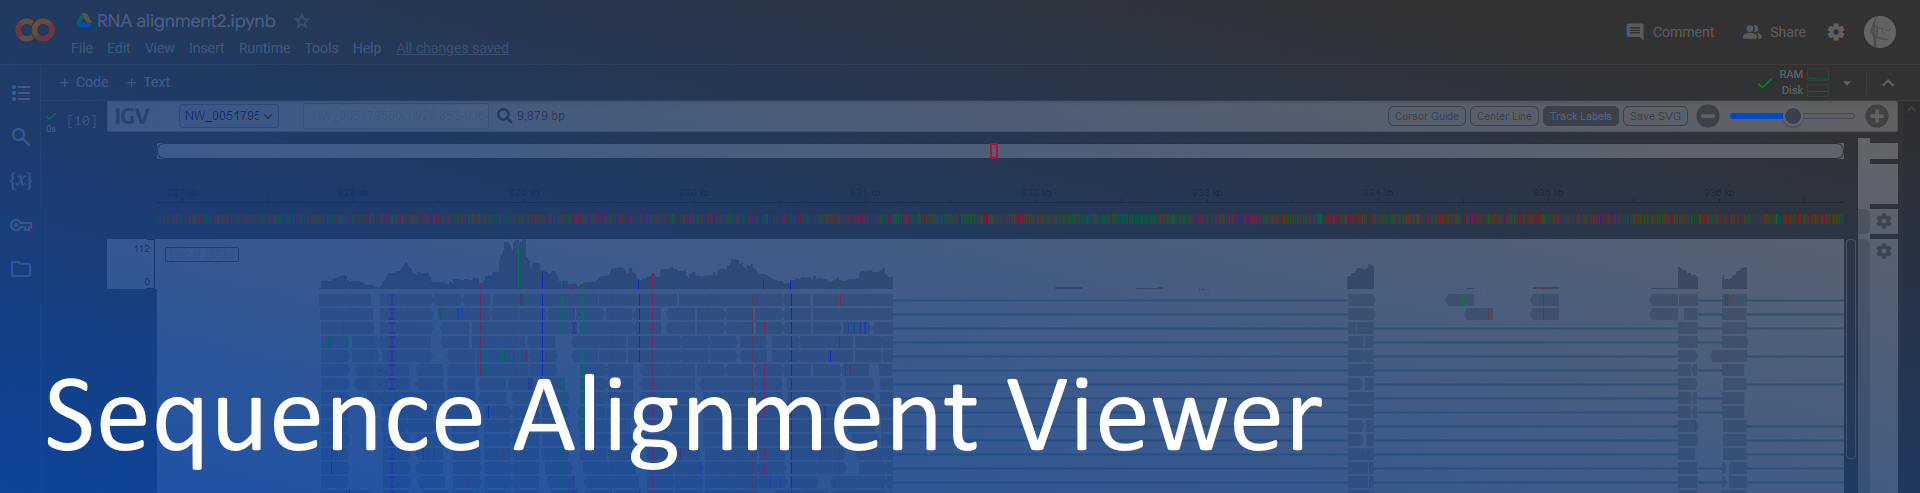

# Sequence Alignment Viewer

##### Downloader, SRA aligner, and embedded IGV viewer, all-in-one.
##### Unofficial notebook, courtesy of Wolfgang S.

In [5]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
!conda install -c bioconda samtools
!conda install -c biobuilds hisat2

!mkdir -p /root/tools/ncbi_sra_tools/
%cd /root/tools/ncbi_sra_tools/
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
!tar -xvzf sratoolkit.3.0.0-ubuntu64.tar.gz

!echo $PATH
import os
os.environ['PATH'] += ":/root/tools/ncbi_sra_tools/sratoolkit.3.0.0-ubuntu64/bin"
!echo $PATH

#NCBI datasets command line tool, will use later
!conda install -c conda-forge ncbi-datasets-cli

!conda install -c bioconda samtools

!pip install igv-notebook

# You probably don't neede this
# !conda install -c bioconda igv

Solving environment: / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - samtools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.11.17 |       hbcca054_0         151 KB  conda-forge
    certifi-2023.11.17         |     pyhd8ed1ab_0         155 KB  conda-forge
    curl-7.88.1                |       hdc1c0ab_1          86 KB  conda-forge
    openssl-3.2.0              |       hd590300_1         2.7 MB  conda-forge
    python_abi-3.10            |          4_cp310           6 KB  conda

### ↓ Run this code below, but just hit `<Enter>`; don't configure anything.
It should return `Segmentation Fault`, this is normal.

In [2]:
!vdb-config --interactive-mode textual --interactive
!vdb-config --interactive

     vdb-config interactive

  data source

   NCBI SRA: enabled (recommended) (1)


  local workspaces: local file caching: enabled (recommended) (6)

  Open Access Data
cached (recommended) (3)
location: '' (4)


To cancel and exit      : Press <Enter>
To update and continue  : Enter corresponding symbol and Press <Enter>

Your choice > 

Canceling...




2023-12-06T19:47:13 vdb-config.3.0.0 fatal: SIGNAL - Segmentation fault 


# A. Burtoni

In [ ]:
#SRR17414747 - A. Burtoni brain sample
#https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE192958

#link to how-to on SRA Toolkit:
#https://github.com/ncbi/sra-tools/wiki/HowTo:-fasterq-dump
#https://www.ncbi.nlm.nih.gov/sra/docs/sradownload/

#To-do: find progress bar for 8min SRA download

In [3]:
#should take around 8-9min for downlaod
!time fasterq-dump SRR17414747 -O FASTQ_files/

spots read      : 12,705,161
reads read      : 25,410,322
reads written   : 25,410,322

real	6m23.663s
user	2m5.813s
sys	0m42.029s


In [ ]:
#should only take ~30sec
!datasets download genome accession GCF_000239415.1 --include gff3,rna,cds,protein,genome,seq-report
#Do I need all of these to properly display BAM alignment later?

!unzip ncbi_dataset.zip

# ↓ may take 18min+
(18:15 previous benchmark)

In [5]:
!hisat2-build -p 2 \
'/root/tools/ncbi_sra_tools/ncbi_dataset/data/GCF_000239415.1/GCF_000239415.1_AstBur1.0_genomic.fna' \
'/root/tools/ncbi_sra_tools/ncbi_dataset/data/GCF_000239415.1/genome'

Settings:
  Output files: "/root/tools/ncbi_sra_tools/ncbi_dataset/data/GCF_000239415.1/genome.*.ht2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Local offset rate: 3 (one in 8)
  Local fTable chars: 6
  Local sequence length: 57344
  Local sequence overlap between two consecutive indexes: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  /root/tools/ncbi_sra_tools/ncbi_dataset/data/GCF_000239415.1/GCF_000239415.1_AstBur1.0_genomic.fna
Reading reference sizes
  Time reading reference sizes: 00:00:08
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:07
  Time to read SNPs and splice sites: 00:00:00
Using parameters --bmax 131053058 --dcv 1024
  Doing 

# ↓ Expected to take at least 17m27s

In [6]:
!mkdir -p mapped

#not sure why it has the '_1' and '_2'
!hisat2 -p 2 \
-x ./ncbi_dataset/data/GCF_000239415.1/genome \
-U ./FASTQ_files/SRR17414747_1.fastq \
| samtools view -Sb -o ./mapped/ABurtoni_sample1.bam

12705161 reads; of these:
  12705161 (100.00%) were unpaired; of these:
    2567378 (20.21%) aligned 0 times
    10039277 (79.02%) aligned exactly 1 time
    98506 (0.78%) aligned >1 times
79.79% overall alignment rate


In [7]:
#4m25s
!samtools sort \
./mapped/ABurtoni_sample1.bam \
-o ./mapped/ABurtoni_sample1.sort.bam

[bam_sort_core] merging from 5 files and 1 in-memory blocks...


In [8]:
!samtools index \
-c ./mapped/ABurtoni_sample1.sort.bam \
./mapped/ABurtoni_sample1.sort.bam.bai

In [9]:
!samtools faidx \
'ncbi_dataset/data/GCF_000239415.1/GCF_000239415.1_AstBur1.0_genomic.fna'

# from local genome and local alignment files
src: https://notebooks.gesis.org/binder/jupyter/user/igvteam-igv-notebook-8mpaahd9/notebooks/examples/Colab.ipynb

https://github.com/igvteam/igv-notebook


#test alignment:


In [3]:
%cd /content/
!curl -O -J \
'https://s3.amazonaws.com/igv.org.demo/gstt1_sample.bam'
!curl -O -J \
'https://s3.amazonaws.com/igv.org.demo/gstt1_sample.bam.bai'
!curl -O -J \
'https://s3.amazonaws.com/igv.org.test/data/roi/roi_bed_1.bed' \

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60872  100 60872    0     0   379k      0 --:--:-- --:--:-- --:--:--  381k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12184  100 12184    0     0  78131      0 --:--:-- --:--:-- --:--:-- 78102
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   115  100   115    0     0    896      0 --:--:-- --:--:-- --:--:--   898
curl: (6) Could not resolve host: \


In [ ]:
import igv_notebook
igv_notebook.init()
igv_browser= igv_notebook.Browser(
    {
        "genome": "hg19",
        "locus": "chr22:24,376,166-24,376,456",
        "tracks": [{
            "name": "BAM",
            "path": "/content/gstt1_sample.bam",
            "indexPath": "/content/gstt1_sample.bam.bai",
            "format": "bam",
            "type": "alignment"
        }],
        "roi": [
            {
                "name": "ROI set 1",
                "url": "https://s3.amazonaws.com/igv.org.test/data/roi/roi_bed_1.bed",
                "indexed": False,
                "color": "rgba(94,255,1,0.25)"
            }
        ]
    }
)

# A. Burtoni alignment:
#  
#  

In [ ]:
#the below code only started working when I did '%cd /content', so I might need to repeat that

In [10]:
# https://notebooks.gesis.org/binder/jupyter/user/igvteam-igv-notebook-5ezpa167/tree/examples
# https://notebooks.gesis.org/binder/jupyter/user/igvteam-igv-notebook-5ezpa167/notebooks/examples/Colab.ipynb
import igv_notebook

igv_notebook.init()

b = igv_notebook.Browser(
    {
        "reference": {
            "id": "GCF_000239415.1",
            "name": "A_Burtoni",
            "fastaPath": "/root/tools/ncbi_sra_tools/ncbi_dataset/data/GCF_000239415.1/GCF_000239415.1_AstBur1.0_genomic.fna",
            "indexPath": "/root/tools/ncbi_sra_tools/ncbi_dataset/data/GCF_000239415.1/GCF_000239415.1_AstBur1.0_genomic.fna.fai",
            "tracks": [{
                "name": "Local BAM",
                "path": "/root/tools/ncbi_sra_tools/mapped/ABurtoni_sample1.sort.bam",
                "indexPath": "/root/tools/ncbi_sra_tools/mapped/ABurtoni_sample1.sort.bam.bai",
                "format": "bam",
                "type": "alignment",
                # "color": "rgba(94,255,1,0.25)",
                "height": "600"
            }]
        },
        "locus": "NW_005179500.1:926,853-936,731"
    }
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>